_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

* Student names: Ahmed Eldably, Aakarsh Nair, Andreas Kotzur
* LLM Disclaimer:  Chat GPT o3, Gemini, Copilot. For plotting and answer verification, and neuroscience context.

# Coding Lab 2

## Introduction

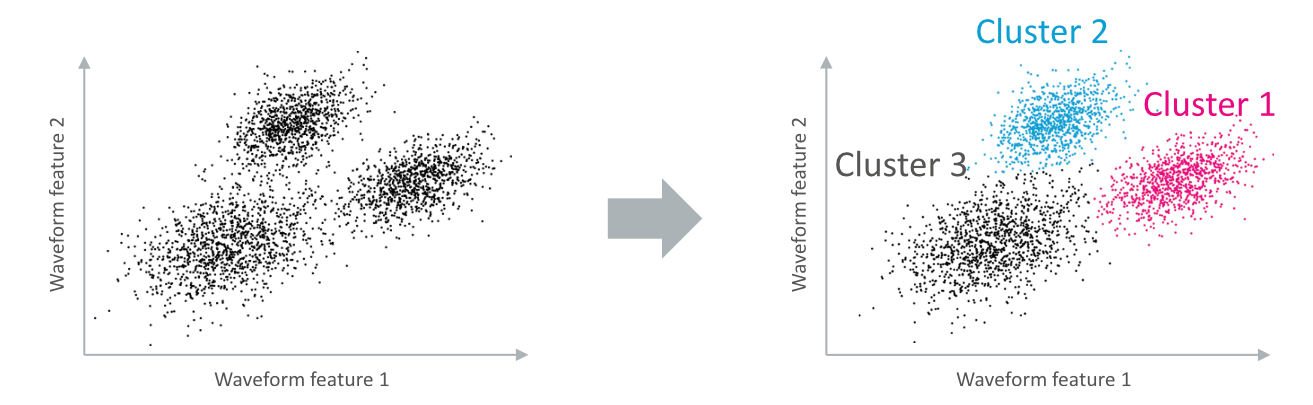

In this coding lab, we continue with the data from the first coding lab and finalize the Spike Sorting pipeline.
In particular, we use the created feature space to identify individual clusters by fitting a Gaussian Mixture Model.
To verify that this model does what we want, we first create a synthetic Toy Dataset and apply the model to that.

- __Data__: Use the saved data `nds_cl_1_*.npy` from Coding Lab 1. Or, if needed, download the data files ```nds_cl_1_*.npy``` from ILIAS and save it in the subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

In [31]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from __future__ import annotations

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-05-04 20:17:16CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 8.31.0

sklearn: 1.6.1

numpy     : 2.2.2
sklearn   : 1.6.1
matplotlib: 3.10.0
scipy     : 1.15.1

Watermark: 2.5.0



In [32]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [33]:
# replace by path to your solutions
b = np.load("../data/nds_cl_1_features.npy")
s = np.load("../data/nds_cl_1_spiketimes_s.npy")
t = np.load("../data/nds_cl_1_spiketimes_t.npy")
w = np.load("../data/nds_cl_1_waveforms.npy")

## Task 1: Generate toy data

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_3 = \begin{bmatrix}0\\4\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

*Grading: 2 pts*


In [4]:
def sample_data(
    n_samples: int, m: np.ndarray, S: np.ndarray, p: np.ndarray, random_seed: int = 0
) -> tuple[np.ndarray, np.ndarray]:
    """Generate n_samples samples from a Mixture of Gaussian distribution with
    means m, covariances S and priors p.

    Parameters
    ----------

    n_samples: int
        Number of samples

    m: np.ndarray, (n_clusters, n_dims)
        Means

    S: np.ndarray, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.ndarray, (n_clusters, )
        Cluster weights / probablities

    random_seed: int
        Random Seed

    Returns
    -------

    labels: np.array, (n_samples, )
        Grund truth labels.

    x: np.array, (n_samples, n_dims)
        Data points
    """
    # ensure reproducibility using a random number generator
    # hint: access random functions of this generator
    rng = np.random.default_rng(random_seed)

    # ------------------------------------------------------
    # draw labeled points from mixture of Gaussians (1 pt)
    # ------------------------------------------------------
    n_clusters, n_dims = m.shape

    # Sample component labels using the categorical distribution
    labels = rng.choice(n_clusters, size=n_samples, p=p)

    # Sample points for each label
    x = np.empty((n_samples, n_dims))
    for i in range(n_clusters):
        # Find indices of samples to draw from cluster i
        idx = np.where(labels == i)[0]
        if len(idx) > 0:
            x[idx] = rng.multivariate_normal(mean=m[i], cov=S[i], size=len(idx))

    return labels, x

In [5]:
N = 1000  # total number of samples

p = np.array([0.3, 0.5, 0.2])  # percentage of each cluster
m = np.array([[0.0, 0.0], [5.0, 1.0], [0.0, 4.0]])  # means

S1 = np.array([[1.0, 0.0], [0.0, 1.0]])
S2 = np.array([[2.0, 1.0], [1.0, 2.0]])
S3 = np.array([[1.0, -0.5], [-0.5, 1.0]])
S = np.stack([S1, S2, S3])  # cov

labels, x = sample_data(N, m, S, p)

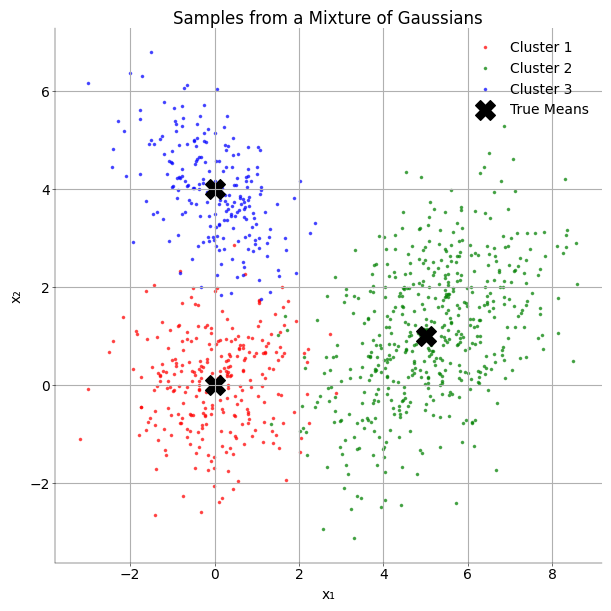

In [6]:
# ----------------------------------------------
# plot points from mixture of Gaussians (1 pt)
# ----------------------------------------------
colors = ["red", "green", "blue"]
labels_names = ["Cluster 1", "Cluster 2", "Cluster 3"]

fig, ax = plt.subplots(figsize=(6, 6), layout="constrained")

# scatter by true label
for i in range(3):
    ax.scatter(
        x[labels == i, 0],
        x[labels == i, 1],
        s=10,
        alpha=0.6,
        label=labels_names[i],
        color=colors[i],
    )

# overlay the means
ax.scatter(m[:, 0], m[:, 1], marker="X", s=200, c="black", label="True Means")

ax.set_title("Samples from a Mixture of Gaussians")
ax.set_xlabel("x₁")
ax.set_ylabel("x₂")
ax.legend()
ax.grid(True)
plt.show()

## Task 2: Implement a Gaussian mixture model

Implement the EM algorithm to fit a Gaussian mixture model in `fit_mog()`.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. Test it on the toy dataset specifying the correct number of clusters and make sure the code works correctly. Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.  

*Grading: 6 pts*


In [7]:
from scipy.linalg import cholesky, solve_triangular


def initialize_with_kmeans(x, n_clusters, random_seed):
    """Initialize cluster centers using k-means++."""
    kmeans = KMeans(
        n_clusters=n_clusters, init="k-means++", n_init=10, random_state=random_seed
    )
    kmeans.fit(x)
    return kmeans.cluster_centers_


def fit_mog(
    x: np.ndarray,
    n_clusters: int,
    n_iters: int = 10,
    random_seed: int = 0,
    init: str = "random",
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Fit Mixture of Gaussian model using EM algo.

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    n_clusters: int
        Number of clusters

    n_iters: int
        Maximal number of iterations.

    random_seed: int
        Random Seed


    Returns
    -------

    labels: np.array, (n_samples)
        Cluster labels

    m: list or np.array, (n_clusters, n_dims)
        Means

    S: list or np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: list or np.array, (n_clusters, )
        Cluster weights / probablities
    """
    rng = np.random.default_rng(random_seed)
    n_samples, n_dims = x.shape

    # Initialization
    means = (
        initialize_with_kmeans(x, n_clusters, random_seed)
        if init == "kmeans"
        else x[rng.choice(n_samples, n_clusters, replace=False)]
    )
    covariances = np.array([np.eye(n_dims) for _ in range(n_clusters)])
    weights = np.ones(n_clusters) / n_clusters

    reg_covar = 1e-6  # Regularization added to covariances
    tol = 1e-4  # Convergance tolerance

    prev_ll = -np.inf
    for step in range(n_iters):
        log_prob = np.zeros((n_samples, n_clusters))

        # E-step
        for k in range(n_clusters):
            try:
                L = cholesky(covariances[k] + reg_covar * np.eye(n_dims), lower=True)
            except np.linalg.LinAlgError:
                L = cholesky(covariances[k] + 1e-3 * np.eye(n_dims), lower=True)

            diff = x - means[k]
            y = solve_triangular(L, diff.T, lower=True)
            mahalanobis = np.sum(y**2, axis=0)
            log_det = 2.0 * np.sum(np.log(np.diag(L)))
            log_prob[:, k] = -0.5 * (
                mahalanobis + log_det + n_dims * np.log(2 * np.pi)
            ) + np.log(weights[k] + 1e-12)

        # Log-sum-exp
        max_log_prob = np.max(log_prob, axis=1, keepdims=True)
        log_responsibilities = log_prob - max_log_prob
        res = np.exp(log_responsibilities)
        res_sum = np.clip(np.sum(res, axis=1, keepdims=True), 1e-12, np.inf)
        res /= res_sum
        log_likelihood = np.sum(np.log(res_sum) + max_log_prob)

        # M-step
        Nk = np.sum(res, axis=0)
        means = (res.T @ x) / (Nk[:, np.newaxis] + 1e-12)

        covariances = np.zeros((n_clusters, n_dims, n_dims))
        for k in range(n_clusters):
            diff = x - means[k]
            weighted_diff = diff * np.sqrt(res[:, k : k + 1])
            cov_k = (weighted_diff.T @ weighted_diff) / (Nk[k] + 1e-12)
            cov_k += reg_covar * np.eye(n_dims)

            try:
                U, s, V = np.linalg.svd(cov_k)
                if np.min(s) < 1e-10 or np.max(s) / np.min(s) > 1e6:
                    cov_k += 1e-3 * np.eye(n_dims)
            except np.linalg.LinAlgError:
                cov_k += 1e-3 * np.eye(n_dims)

            covariances[k] = cov_k

        weights = Nk / n_samples

        # Reinitialize empty clusters
        empty_clusters = np.where(Nk < 1e-6)[0]
        for k in empty_clusters:
            means[k] = x[rng.choice(n_samples)]
            covariances[k] = np.eye(n_dims)
            weights[k] = 1.0 / n_clusters

        # Convergence check: relative change in LL
        if step > 0:
            rel_change = abs(log_likelihood - prev_ll) / (abs(prev_ll) + 1e-12)
            if rel_change < tol:
                break

        prev_ll = log_likelihood
        prev_means = means.copy()
        prev_covariances = covariances.copy()

    labels = np.argmax(res, axis=1)
    return labels, means, covariances, weights

Run Mixture of Gaussian on toy data

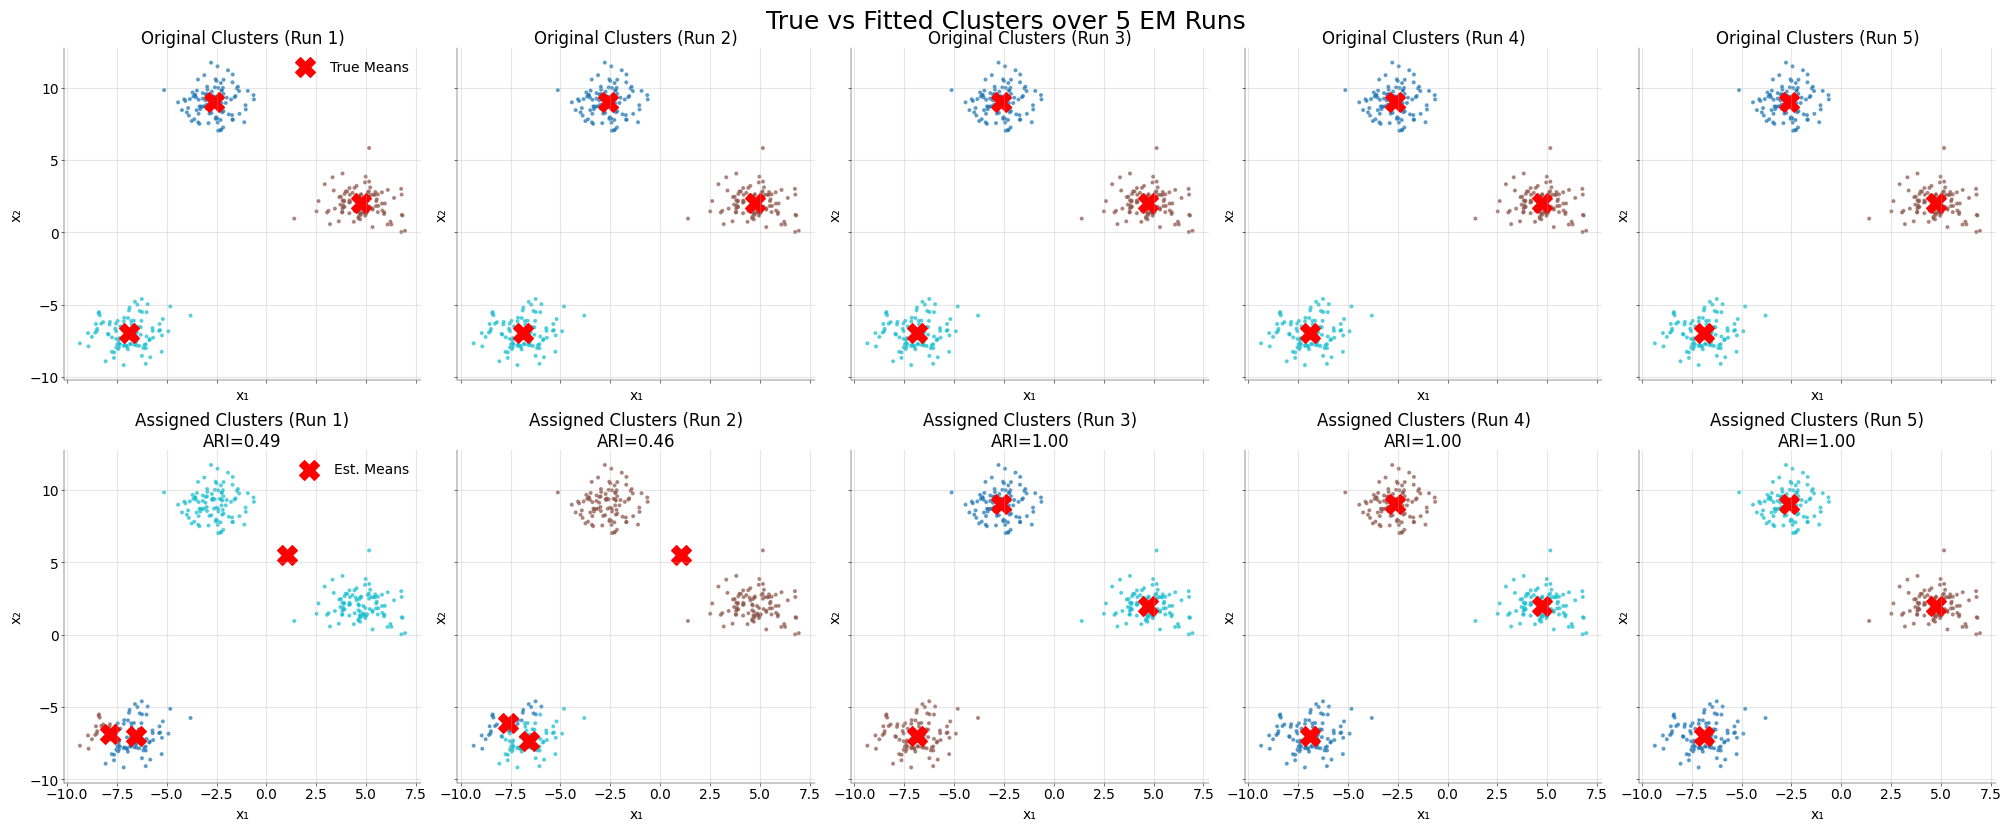

In [99]:
# -------------------------------------------------------------------------
# Run the algorithm 5 times on the toy data, plot and compare original and
# assigned clusters and answer the questions (1+1 pts)
# -------------------------------------------------------------------------
from sklearn.datasets import make_blobs

# 1) Generate toy data & ground truth
K = 3
X, true_labels = make_blobs(n_samples=300, centers=K, n_features=2, random_state=42)
true_means = np.vstack([X[true_labels == k].mean(axis=0) for k in range(K)])

# 2) Prepare figure
fig, axes = plt.subplots(
    2, 5, figsize=(20, 8), sharex=True, sharey=True, constrained_layout=True
)

# 3) Top row: ground truth
for i in range(5):
    ax = axes[0, i]
    ax.scatter(X[:, 0], X[:, 1], c=true_labels, cmap="tab10", s=15, alpha=0.6)
    ax.scatter(
        true_means[:, 0],
        true_means[:, 1],
        c="red",
        marker="X",
        s=200,
        label="True Means",
    )
    ax.set_title(f"Original Clusters (Run {i+1})")
    if i == 0:
        ax.legend(loc="upper right")
    ax.grid(alpha=0.3)

# 4) Bottom row: EM fits + ARI
for i in range(5):
    seed = i
    labels_pred, means_pred, _, _ = fit_mog(
        X, n_clusters=K, random_seed=seed, n_iters=20
    )
    ari = adjusted_rand_score(true_labels, labels_pred)

    ax = axes[1, i]
    ax.scatter(X[:, 0], X[:, 1], c=labels_pred, cmap="tab10", s=15, alpha=0.6)
    ax.scatter(
        means_pred[:, 0],
        means_pred[:, 1],
        c="red",
        marker="X",
        s=200,
        label="Est. Means",
    )
    ax.set_title(f"Assigned Clusters (Run {i+1})\nARI={ari:.2f}")
    if i == 0:
        ax.legend(loc="upper right")
    ax.grid(alpha=0.3)

# 5) Label axes and show
for ax in axes.flatten():
    ax.set_xlabel("x₁")
    ax.set_ylabel("x₂")

plt.suptitle("True vs Fitted Clusters over 5 EM Runs", fontsize=18, y=1.02)
plt.show()

### Questions

1) Do all runs converge to good solutions? If not, which one would you pick (only visual inspection required) as the best one?

Runs 1 and 2 clearly get stuck in suboptimal local minima (ARI ≈ 0.49 and 0.46), whereas Runs 3–5 all recover the true three clusters perfectly (ARI = 1.00).  By visual inspection, I’d pick Run 3 (the first perfect recovery) as my best solution, although Runs 4 and 5 are equally good.


2) Do you get the same colors (=labels) in your best assignment(s) compared to the groundtruth? Does it have to be that way or not? Why?

No, the colors/label‐numbers don’t have to match, because cluster labels are only defined up to a permutation. We measure clustering accuracy with permutation‐invariant metrics (like ARI), and one can always apply a post‐hoc label matching (e.g. via the Hungarian algorithm) if one wants the colors to align for display, but that isn’t required here.

## Bonus Task (Optional): Mixture of drifting t-distributions

Instead of a simple Gaussian Mixture Model, more advanced algorithms can be implemented.
Implement a basic version of the mixture of drifting t-distributions (follow https://github.com/aecker/moksm/blob/master/MoT_Kalman.pdf).
What is the advantage of that method?

_Grading: 2 BONUS Points._


_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._

Q: What is the advantage of that method?
- Heavy‐tailed robustness: replacing Gaussians with Student-t components down-weights outliers automatically, giving more stable clusters in noisy spike data.
- Drift tracking: by coupling components means over time via a simple Kalman-filter step, the model lets clusters “move” slowly (e.g. electrode drift) while still sharing strength across windows.

In [14]:
# YOUR CODE HERE
from scipy.linalg import cholesky, solve_triangular
from scipy.special import digamma, gammaln
from scipy.stats import multivariate_normal


def fit_mot(
    x: np.ndarray,
    n_clusters: int,
    nu: float = 4.0,
    n_iters: int = 20,
    random_seed: int = 0,
    init: str = "kmeans",
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Fit a mixture of Student-t distributions by EM (static version).

    Parameters
    ----------
    x            : (n, d) data
    n_clusters   : number of components
    nu           : degrees of freedom
    n_iters      : max EM iterations
    random_seed  : RNG seed
    init         : 'random' or 'kmeans'

    Returns
    -------
    labels       : (n,)
    means        : (K, d)
    covariances  : (K, d, d)
    weights      : (K,)
    """
    rng = np.random.default_rng(random_seed)
    n, d = x.shape

    # 1) init means/covs/weights
    if init == "kmeans":
        means = initialize_with_kmeans(x, n_clusters, random_seed)
    else:
        means = x[rng.choice(n, n_clusters, replace=False)]
    covs = np.array([np.cov(x, rowvar=False) for _ in range(n_clusters)])
    weights = np.ones(n_clusters) / n_clusters

    # latent “scale” variables u_{ik} for t-distribution
    # E-step will compute u and responsibilities r
    for it in range(n_iters):
        # E-step: compute responsibilities and u
        log_prob = np.zeros((n, n_clusters))
        u = np.zeros((n, n_clusters))
        for k in range(n_clusters):
            # Mahalanobis distance
            L = cholesky(covs[k], lower=True)
            diff = x - means[k]
            y = solve_triangular(L, diff.T, lower=True)
            mahal = np.sum(y**2, axis=0)

            # Student-t log-pdf
            const = (
                gammaln((nu + d) / 2)
                - gammaln(nu / 2)
                - 0.5 * d * np.log(nu * np.pi)
                - np.sum(np.log(np.diag(L)))
            )
            log_t = const - 0.5 * (nu + d) * np.log1p(mahal / nu)

            log_prob[:, k] = np.log(weights[k] + 1e-12) + log_t

            # expected scale: u = (nu+d)/(nu + mahal)
            u[:, k] = (nu + d) / (nu + mahal + 1e-12)

        # normalize responsibilities
        log_res = log_prob - log_prob.max(axis=1, keepdims=True)
        resp = np.exp(log_res)
        resp /= resp.sum(axis=1, keepdims=True)

        # M-step: update weights, means, covariances
        Nk = resp.sum(axis=0)
        weights = Nk / n

        # weighted by u
        for k in range(n_clusters):
            # update means
            means[k] = (resp[:, k] * u[:, k] @ x) / (
                np.sum(resp[:, k] * u[:, k]) + 1e-12
            )

            # update covariance
            diff = x - means[k]
            covs[k] = (resp[:, k] * u[:, k] * diff.T) @ diff
            covs[k] /= Nk[k]
            covs[k] += 1e-6 * np.eye(d)

    labels = np.argmax(resp, axis=1)
    return labels, means, covs, weights

## Task 3: Model complexity
A priori we do not know how many neurons we recorded. Extend your algorithm with an automatic procedure to select the appropriate number of mixture components (clusters). Base your decision on the Bayesian Information Criterion:

$BIC = -2L+P \log N,$

where $L$ is the log-likelihood of the data under the best model, $P$ is the number of parameters of the model and $N$ is the number of data points. You want to minimize the quantity. Plot the BIC as a function of mixture components. What is the optimal number of clusters on the toy dataset?

You can also use the BIC to make your algorithm robust against suboptimal solutions due to local minima. Start the algorithm multiple times and pick the best solutions. You will notice that this depends a lot on which initialization strategy you use.

*Grading: 5 pts*


### Question (0.5 pts)

1) What is the number of parameters of the model?

$P = (K - 1) \;+\; K\,d \;+\; K\,\frac{d(d+1)}{2}$


where

- $(K - 1)$ comes from the $K$  mixture weights (they sum to 1),  
- $K\,d$ comes from the $K$  mean-vectors, and  
- $K\,\dfrac{d(d+1)}{2}$ comes from the $K$  full $d\times d$  covariance matrices (each symmetric).

($K = 3$, $d = 2$), this gives:

$$
P = (3 - 1) \;+\; 3 \cdot 2 \;+\; 3 \cdot \frac{2 \cdot 3}{2}
\;=\; 2 \;+\; 6 \;+\; 9
\;=\; 17.
$$


In [18]:
from scipy.stats import multivariate_normal
from scipy.special import logsumexp


def mog_bic(
    x: np.ndarray, means: np.ndarray, covariances: np.ndarray, weights: np.ndarray
) -> tuple[float, float]:
    """Compute the BIC for a fitted Mixture of Gaussian model

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    m: np.array, (n_clusters, n_dims)
        Means

    S: np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.array, (n_clusters, )
        Cluster weights / probablities

    Return
    ------

    bic: float
        BIC

    LL: float
        Log Likelihood
    """

    # -------------------------
    # implement the BIC (1.5 pts)
    # -------------------------
    n, d = x.shape
    K = weights.size

    # 1) build (n,K) log-probabilities
    log_prob = np.zeros((n, K))
    for k in range(K):
        log_prob[:, k] = np.log(weights[k] + 1e-12) + multivariate_normal.logpdf(
            x, mean=means[k], cov=covariances[k], allow_singular=True
        )

    # 2) per-point log P(x_i) via logsumexp, then sum
    log_lik = np.sum(logsumexp(log_prob, axis=1))

    # 3) count parameters for FULL covariances:
    #    (K-1) weights + K*d means + K*(d*(d+1)/2) covariances
    m = (K - 1) + K * d + K * (d * (d + 1) // 2)

    # 4) BIC
    bic = -2 * log_lik + m * np.log(n)
    return bic, log_lik

In [19]:
# Range of cluster counts (K from 2 to 9)
K = np.arange(2, 10)

# Number of random seeds
num_seeds = 10

# Initialize matrices to store BIC and log-likelihood values
bic_matrix = np.zeros((num_seeds, len(K)))
ll_matrix = np.zeros((num_seeds, len(K)))

# Fit the model with multiple initializations and calculate BIC/log-likelihood
for i, k in enumerate(K):
    for j in range(num_seeds):
        # Fit GMM using fit_mog (with a fixed random seed per run)
        labels, means, covariances, weights = fit_mog(
            X, n_clusters=k, n_iters=50, random_seed=j, init="kmeans"
        )

        # Calculate BIC and log-likelihood for the fitted model
        bic_matrix[j, i], ll_matrix[j, i] = mog_bic(X, means, covariances, weights)

Optimal number of clusters by BIC = 3


/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_14100/1234725949.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


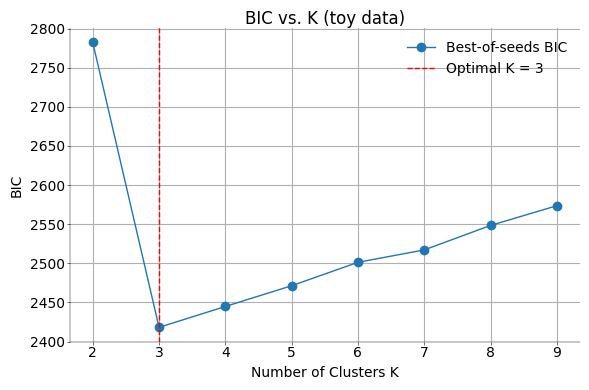

In [20]:
# ------------------------------------------------------------------------------------------
# Plot the result and answer the questions (1+1 pts)
# Don't forget to plot your robust estimate and highlight the estimated number of clusters!
# ------------------------------------------------------------------------------------------

# 1) Compute best‐of‐seeds BIC for each K
best_bic_per_K = np.min(bic_matrix, axis=0)

# 2) Find the K that minimizes that
optimal_k = K[np.argmin(best_bic_per_K)]
print(f"Optimal number of clusters by BIC = {optimal_k}")

# 3) Plot best‐of‐seeds curve
plt.figure(figsize=(6, 4))
plt.plot(K, best_bic_per_K, marker="o", label="Best-of-seeds BIC")
plt.axvline(optimal_k, color="red", linestyle="--", label=f"Optimal K = {optimal_k}")
plt.xlabel("Number of Clusters K")
plt.ylabel("BIC")
plt.title("BIC vs. K (toy data)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Questions

1) What happens to the BIC if the model got stuck in a local minimum? For your reasoning, you can also refer to Task 2.

If EM converges to a poor local minimum, the log-likelihood \(L\) is lower than optimal. Since $BIC = -2L+P \log N,$ a smaller \(L\) makes –2 L larger, so the BIC for that $K$ goes up, falsely penalizing the model.


2) The goal is to estimate which number of clusters best fits the data using the BIC. Therefore, what qualifies as a robust estimate? Explain your reasoning!
   
_(Hint: think about which number of cluster you would use and why)_

A robust $K$ is the one that consistently yields the lowest BIC across multiple restarts. In practice, for each candidate \(K\) we:
1. Run EM several times with different seeds.  
2. Record the minimum (“best-of-seeds”) BIC for that \(K\).  
3. Choose the $K$ whose best-of-seeds BIC is lowest.  
4. Optionally, check that this same $K$ is the mode of the seed-wise minimizers. 

## Task 4: Spike sorting using Mixture of Gaussian 
Run the full algorithm on your set of extracted features (MoG fitting + model complexity selection).

Show the plot of the BIC as a function of the number of mixture components on the real data, highlight the robust estimate and based on that the best number of clusters.

For the best model, make scatter plots of the first PCs on all four channels (6 plots). Color-code each data point according to its class label in the model with the optimal number of clusters. In addition, indicate the position (mean) of the clusters in your plot.

*Grading: 3 pts*


In [34]:
# -------------------------------------------------------------
# Run the algorithm on the set of extracted features (0.5 pts)
# -------------------------------------------------------------

# 1) PARAMETERS & DATA
K = np.arange(2, 31)  # test K = 2…30

# Load the extracted feature data
features = np.load("../data/nds_cl_1_features.npy")

# Check the shape of the data
print(f"Shape of the feature data: {features.shape}")

Shape of the feature data: (33983, 12)


In [73]:
# 2) RUN fit_mog / mog_bic LOOP

# keeping track of the best bic
bic_best = []
for k in K:
    # choose number of restarts
    seeds = 5 if k <= 20 else 3
    bic_vals = []
    for seed in range(seeds):
        labels, means, covs, weights = fit_mog(
            features,
            n_clusters=k,
            random_seed=seed,
            n_iters=100 if k <= 20 else 50,
            init="kmeans",
        )
        bic, ll = mog_bic(features, means, covs, weights)
        bic_vals.append(bic)
    bic_best.append(min(bic_vals))

bic_best = np.array(bic_best)

Optimal number of clusters (2–30 range): 15


/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_14100/2597602894.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


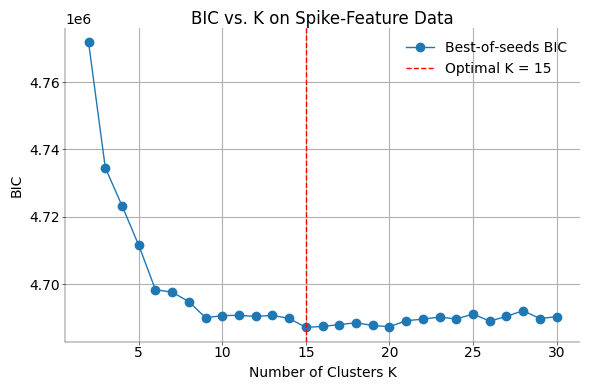

In [74]:
# ----------------------------------------------------------------------------------------------------------------------
# Plot the BIC over number of mixture components and highlight robust estimate and optimal number of clusters (0.5 pts)
# ----------------------------------------------------------------------------------------------------------------------

# 3) SELECT OPTIMAL K
opt_k = K[np.argmin(bic_best)]
print(f"Optimal number of clusters (2–30 range): {opt_k}")

# 4) PLOT BIC vs K & HIGHLIGHT opt_k
plt.figure(figsize=(6, 4))
plt.plot(K, bic_best, marker="o", label="Best‐of‐seeds BIC")
plt.axvline(opt_k, color="red", linestyle="--", label=f"Optimal K = {opt_k}")
plt.xlabel("Number of Clusters K")
plt.ylabel("BIC")
plt.title("BIC vs. K on Spike‐Feature Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Refit model with lowest BIC and plot data points

In [35]:
opt_k = 15
# 5) FIT FINAL MODEL & SCATTER PLOTS OF FIRST 4 FEATURES (6 PAIRWISE)
labels_final, means_final, covs_final, weights_final = fit_mog(
    features, n_clusters=opt_k, random_seed=0, n_iters=200, init="kmeans"
)

/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_14100/657243384.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


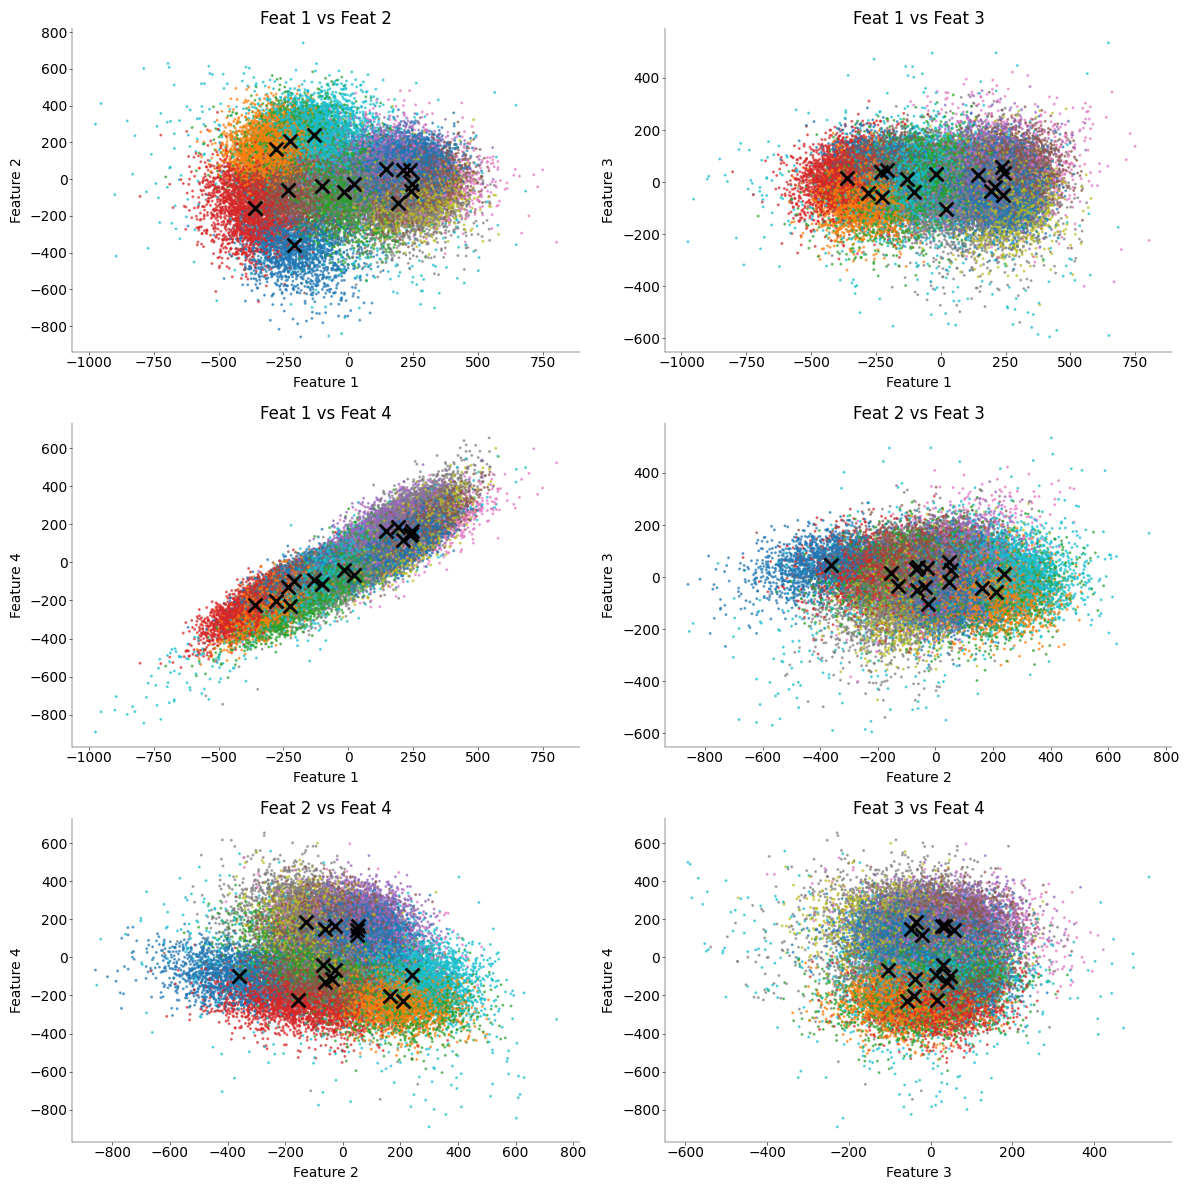

In [ ]:
# ------------------------------------------------------------------------------------------------------------------
# Create scatterplots of the first PCs under the best model for all pairwise combinations of the 4 channels. (1 pt)
# ------------------------------------------------------------------------------------------------------------------
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
plt.figure(figsize=(12, 12))
for idx, (i, j) in enumerate(pairs, start=1):
    ax = plt.subplot(3, 2, idx)
    ax.scatter(
        features[:, i], features[:, j], c=labels_final, cmap="tab10", s=5, alpha=0.6
    )
    ax.scatter(
        means_final[:, i], means_final[:, j], c="black", marker="x", s=100, linewidths=2
    )
    ax.set_xlabel(f"Feature {i+1}")
    ax.set_ylabel(f"Feature {j+1}")
    ax.set_title(f"Feat {i+1} vs Feat {j+1}")
plt.tight_layout()
plt.show()

## Task 5: Cluster separation and Correlograms

As postprocessing, implement the calculation of auto- and cross correlograms over the spike times.

Plot the (auto-/cross-) correlograms, displaying a time frame of -30ms to +30ms. Choose a good bin size and interprete the resulting diagrams.

_Grading: 3 pts_

#### Hints

_It is faster to calculate the histogram only over the spiketimes that are in the displayed range. Filter the spike times before calculating the histogram!_

_For the autocorrelogram, make sure not to include the time difference between a spike and itself (which would be exactly 0)_

_For the correlogram an efficient implementation is very important - looping over all spike times is not feasible. Instead, make use of numpy vectorization and broadcasting - you can use functions such as tile or repeat._

In [57]:
# ----------------------------------------------------------------------
# Implement a function for calculating the spike time differences (1pt)
# ----------------------------------------------------------------------
def cross_time_diff(spiketimes1: np.ndarray, spiketimes2: np.ndarray) -> np.ndarray:
    """Compute the pairwise time differences between two sets of spike times.

    Parameters
    ----------
    spiketimes1: np.ndarray, (n_spikes1, )
        Spike times of the first cluster
    spiketimes2: np.ndarray, (n_spikes2, )
        Spike times of the second cluster

    Return
    ------

    time_diff: np.ndarray, (n_spikes1, n_spikes2)
        Pairwise time differences between the two sets of spike times
        (i.e., spiketimes1[i] - spiketimes2[j])
    """
    # ensure 1-d float64 vectors (seconds)
    t1 = np.asarray(spiketimes1, dtype=float).ravel()
    t2 = np.asarray(spiketimes2, dtype=float).ravel()

    # broadcasting / outer subtraction (memory friendly wrapper)
    # identical to:  t1[:, None] - t2[None, :]
    return np.subtract.outer(t1, t2)

In [ ]:
# -----------------------------------------------------------------------------------
# Calculate and plot auto- and cross correlograms and answer the questions (1+1 pts)
# -----------------------------------------------------------------------------------

# 0) Load sample indices and convert to seconds
fs = 30_000  # Hz
samp_idx = np.load("../data/nds_cl_1_spiketimes_s.npy")
spike_times = samp_idx / fs  # in seconds

# 1) Get your final labels & K
labels = labels_final
K = opt_k

# 2) Group & sort each cluster’s spike times
times_by_cluster = [np.sort(spike_times[labels == k]) for k in range(K)]


# 3) Merge duplicates < 0.5 ms apart
def merge_close(t, tau=0.5e-3):
    t = np.sort(t)
    keep = [0]
    for i in range(1, len(t)):
        if t[i] - t[keep[-1]] > tau:
            keep.append(i)
    return t[keep]


times_by_cluster = [merge_close(t) for t in times_by_cluster]

# 4) Define bins for + or - 30 ms window at 0.5 ms resolution
bin_size = 0.0005  # 0.5 ms in seconds
window = 0.030  # 30 ms
edges = np.arange(-window, window + bin_size, bin_size)
centers = (edges[:-1] + edges[1:]) / 2 * 1e3  # convert to ms
n_bins = len(edges) - 1


# 5) Fixed fast_histogram with bounds check
def fast_histogram(tA, tB, edges):
    w = edges[-1]
    bw = edges[1] - edges[0]
    counts = np.zeros(len(edges) - 1, int)
    j0 = 0

    for t0 in tA:
        # skip tB < t0 - w
        while j0 < len(tB) and tB[j0] < t0 - w:
            j0 += 1
        j = j0
        # accumulate until tB > t0 + w
        while j < len(tB) and tB[j] <= t0 + w:
            dt = tB[j] - t0
            if dt != 0:
                # compute bin index
                idx = int((dt - edges[0]) // bw)
                # guard against floating‐point edge cases
                if 0 <= idx < counts.size:
                    counts[idx] += 1
            j += 1

    return counts


"""
# 6) Pick two clusters to show
c1, c2 = 1, 2
tA = times_by_cluster[c1]
tB = times_by_cluster[c2]

auto_1 = fast_histogram(tA, tA, edges)
cross_12 = fast_histogram(tA, tB, edges)

# 7) Plot the two correlograms
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

ax0.bar(centers, auto_1, width=bin_size * 1e3, color="k")
ax0.set_title(f"Autocorrelogram (cluster {c1})")
ax0.set_xlabel("Lag (ms)")
ax0.set_ylabel("Count")
ax0.axvline(0, color="grey", lw=0.8)
ax0.set_xlim(-30, 30)

ax1.bar(centers, cross_12, width=bin_size * 1e3, color="C1")
ax1.set_title(f"Cross‐correlogram ({c1} vs {c2})")
ax1.set_xlabel("Lag (ms)")
ax1.axvline(0, color="grey", lw=0.8)
ax1.set_xlim(-30, 30)

plt.tight_layout()
plt.show()
"""

'\n# 6) Pick two clusters to show\nc1, c2 = 1, 2\ntA = times_by_cluster[c1]\ntB = times_by_cluster[c2]\n\nauto_1 = fast_histogram(tA, tA, edges)\ncross_12 = fast_histogram(tA, tB, edges)\n\n# 7) Plot the two correlograms\nfig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)\n\nax0.bar(centers, auto_1, width=bin_size * 1e3, color="k")\nax0.set_title(f"Autocorrelogram (cluster {c1})")\nax0.set_xlabel("Lag (ms)")\nax0.set_ylabel("Count")\nax0.axvline(0, color="grey", lw=0.8)\nax0.set_xlim(-30, 30)\n\nax1.bar(centers, cross_12, width=bin_size * 1e3, color="C1")\nax1.set_title(f"Cross‐correlogram ({c1} vs {c2})")\nax1.set_xlabel("Lag (ms)")\nax1.axvline(0, color="grey", lw=0.8)\nax1.set_xlim(-30, 30)\n\nplt.tight_layout()\nplt.show()\n'

In [61]:
"""
# plot clusters
clusters = [0, 1, 2, 3]

fig, axes = plt.subplots(2, len(clusters), figsize=(4 * len(clusters), 8), sharey=True)

for col, k in enumerate(clusters):
    # Autocorrelogram (cluster k)
    auto_counts = fast_histogram(times_by_cluster[k], times_by_cluster[k], edges)
    ax = axes[0, col]
    ax.bar(centers, auto_counts, width=bin_size * 1e3, color="k")
    ax.set_title(f"Auto (cl {k})")
    ax.axvline(0, color="grey", lw=0.8)
    ax.set_xlim(-30, 30)
    if col == 0:
        ax.set_ylabel("Count")
    ax.set_xlabel("Lag (ms)")

    # Cross-correlogram (k vs k+1), guard last index
    if k + 1 < opt_k:
        cross_counts = fast_histogram(
            times_by_cluster[k], times_by_cluster[k + 1], edges
        )
    else:
        cross_counts = np.zeros_like(auto_counts)
    ax = axes[1, col]
    ax.bar(centers, cross_counts, width=bin_size * 1e3, color="C1")
    ax.set_title(f"Cross (cl {k} vs {k+1})")
    ax.axvline(0, color="grey", lw=0.8)
    ax.set_xlim(-30, 30)
    if col == 0:
        ax.set_ylabel("Count")
    ax.set_xlabel("Lag (ms)")

plt.tight_layout()
plt.show()
"""

'\n# plot clusters\nclusters = [0, 1, 2, 3]\n\nfig, axes = plt.subplots(2, len(clusters), figsize=(4 * len(clusters), 8), sharey=True)\n\nfor col, k in enumerate(clusters):\n    # Autocorrelogram (cluster k)\n    auto_counts = fast_histogram(times_by_cluster[k], times_by_cluster[k], edges)\n    ax = axes[0, col]\n    ax.bar(centers, auto_counts, width=bin_size * 1e3, color="k")\n    ax.set_title(f"Auto (cl {k})")\n    ax.axvline(0, color="grey", lw=0.8)\n    ax.set_xlim(-30, 30)\n    if col == 0:\n        ax.set_ylabel("Count")\n    ax.set_xlabel("Lag (ms)")\n\n    # Cross-correlogram (k vs k+1), guard last index\n    if k + 1 < opt_k:\n        cross_counts = fast_histogram(\n            times_by_cluster[k], times_by_cluster[k + 1], edges\n        )\n    else:\n        cross_counts = np.zeros_like(auto_counts)\n    ax = axes[1, col]\n    ax.bar(centers, cross_counts, width=bin_size * 1e3, color="C1")\n    ax.set_title(f"Cross (cl {k} vs {k+1})")\n    ax.axvline(0, color="grey", lw=0.8)

In [62]:
"""
import math


# how many columns vs rows
cols = 4
rows = math.ceil(opt_k / cols)

fig, axes = plt.subplots(
    rows * 2,
    cols,
    figsize=(3 * cols, 2 * rows * 2),
    sharex=True,
    sharey=True,
    constrained_layout=True,
)

for k in range(opt_k):
    r, c = divmod(k, cols)

    # autocorrelogram on row 0..rows-1
    ax_auto = axes[r, c]
    ac = fast_histogram(times_by_cluster[k], times_by_cluster[k], edges)
    ac[np.argmin(np.abs(centers))] = 0
    ax_auto.bar(centers, ac, width=bin_size * 1e3, color="k")
    ax_auto.set_title(f"Auto (cl {k})")
    ax_auto.axvline(0, color="grey", lw=0.8)
    ax_auto.set_xlim(-30, 30)
    if c == 0:
        ax_auto.set_ylabel("Count")
    if r == rows - 1:
        ax_auto.set_xlabel("Lag (ms)")

    # cross-correlogram on row rows..2*rows-1
    ax_cross = axes[rows + r, c]
    if k + 1 < opt_k:
        cc = fast_histogram(times_by_cluster[k], times_by_cluster[k + 1], edges)
    else:
        cc = np.zeros_like(ac)
    ax_cross.bar(centers, cc, width=bin_size * 1e3, color="C1")
    ax_cross.set_title(f"Cross ({k} vs {k+1})")
    ax_cross.axvline(0, color="grey", lw=0.8)
    ax_cross.set_xlim(-30, 30)
    if c == 0:
        ax_cross.set_ylabel("Count")
    if r == rows - 1:
        ax_cross.set_xlabel("Lag (ms)")

# remove any extra axes
for idx in range(opt_k, rows * cols):
    fig.delaxes(axes.flatten()[idx])  # auto row
    fig.delaxes(axes.flatten()[rows * cols + idx])  # cross row

plt.suptitle(
    "Autocorrelograms (top) and Cross-correlograms (bottom) for All Clusters", y=1.02
)
plt.savefig("Autocorrelograms_and_Cross_correlograms_for_all_clusters")
"""

'\nimport math\n\n\n# how many columns vs rows\ncols = 4\nrows = math.ceil(opt_k / cols)\n\nfig, axes = plt.subplots(\n    rows * 2,\n    cols,\n    figsize=(3 * cols, 2 * rows * 2),\n    sharex=True,\n    sharey=True,\n    constrained_layout=True,\n)\n\nfor k in range(opt_k):\n    r, c = divmod(k, cols)\n\n    # autocorrelogram on row 0..rows-1\n    ax_auto = axes[r, c]\n    ac = fast_histogram(times_by_cluster[k], times_by_cluster[k], edges)\n    ac[np.argmin(np.abs(centers))] = 0\n    ax_auto.bar(centers, ac, width=bin_size * 1e3, color="k")\n    ax_auto.set_title(f"Auto (cl {k})")\n    ax_auto.axvline(0, color="grey", lw=0.8)\n    ax_auto.set_xlim(-30, 30)\n    if c == 0:\n        ax_auto.set_ylabel("Count")\n    if r == rows - 1:\n        ax_auto.set_xlabel("Lag (ms)")\n\n    # cross-correlogram on row rows..2*rows-1\n    ax_cross = axes[rows + r, c]\n    if k + 1 < opt_k:\n        cc = fast_histogram(times_by_cluster[k], times_by_cluster[k + 1], edges)\n    else:\n        cc = np

In [63]:
"""
# 1) find the index of the zero‐lag bin
zero_bin = np.argmin(np.abs(centers))

# 2) build a K×K matrix of zero‐lag counts
K = len(times_by_cluster)
sync0 = np.zeros((K, K), int)
for i in range(K):
    for j in range(K):
        cc = fast_histogram(times_by_cluster[i], times_by_cluster[j], edges)
        sync0[i, j] = cc[zero_bin]

# 3) plot as a heatmap
plt.figure(figsize=(6, 5))
plt.imshow(sync0, origin="lower", cmap="Reds")
plt.colorbar(label="Count @ 0 ms")
plt.xlabel("Cluster j")
plt.ylabel("Cluster i")
plt.title("Zero‐Lag Cross‐Correlogram Matrix")
plt.show()
"""

'\n# 1) find the index of the zero‐lag bin\nzero_bin = np.argmin(np.abs(centers))\n\n# 2) build a K×K matrix of zero‐lag counts\nK = len(times_by_cluster)\nsync0 = np.zeros((K, K), int)\nfor i in range(K):\n    for j in range(K):\n        cc = fast_histogram(times_by_cluster[i], times_by_cluster[j], edges)\n        sync0[i, j] = cc[zero_bin]\n\n# 3) plot as a heatmap\nplt.figure(figsize=(6, 5))\nplt.imshow(sync0, origin="lower", cmap="Reds")\nplt.colorbar(label="Count @ 0 ms")\nplt.xlabel("Cluster j")\nplt.ylabel("Cluster i")\nplt.title("Zero‐Lag Cross‐Correlogram Matrix")\nplt.show()\n'

In [56]:
"""
pairs = [(i, j) for i in range(K) for j in range(i + 1, K)]
n_pairs = len(pairs)
cols = 10
rows = math.ceil(n_pairs / cols)

fig, axes = plt.subplots(
    rows,
    cols,
    figsize=(cols * 1.5, rows * 1.5),
    sharex=True,
    sharey=True,
    squeeze=False,
)

for idx, (i, j) in enumerate(pairs):
    r, c = divmod(idx, cols)
    ax = axes[r][c]
    cc = fast_histogram(times_by_cluster[i], times_by_cluster[j], edges)
    ax.bar(centers, cc, width=bin_size * 1e3, color="C1")
    ax.axvline(0, color="grey", lw=0.5)
    ax.set_title(f"{i} vs {j}", fontsize=6)
    ax.set_xlim(-30, 30)
    if r == rows - 1:
        ax.set_xlabel("ms")
    if c == 0:
        ax.set_ylabel("ct")

# delete any unused axes
for idx in range(n_pairs, rows * cols):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.suptitle("Cross‐Correlograms for All Cluster Pairs", y=1.02)
plt.show()
plt.savefig("test_plot.jpeg")
"""

'\npairs = [(i, j) for i in range(K) for j in range(i + 1, K)]\nn_pairs = len(pairs)\ncols = 10\nrows = math.ceil(n_pairs / cols)\n\nfig, axes = plt.subplots(\n    rows,\n    cols,\n    figsize=(cols * 1.5, rows * 1.5),\n    sharex=True,\n    sharey=True,\n    squeeze=False,\n)\n\nfor idx, (i, j) in enumerate(pairs):\n    r, c = divmod(idx, cols)\n    ax = axes[r][c]\n    cc = fast_histogram(times_by_cluster[i], times_by_cluster[j], edges)\n    ax.bar(centers, cc, width=bin_size * 1e3, color="C1")\n    ax.axvline(0, color="grey", lw=0.5)\n    ax.set_title(f"{i} vs {j}", fontsize=6)\n    ax.set_xlim(-30, 30)\n    if r == rows - 1:\n        ax.set_xlabel("ms")\n    if c == 0:\n        ax.set_ylabel("ct")\n\n# delete any unused axes\nfor idx in range(n_pairs, rows * cols):\n    fig.delaxes(axes.flatten()[idx])\n\nplt.tight_layout()\nplt.suptitle("Cross‐Correlograms for All Cluster Pairs", y=1.02)\nplt.show()\nplt.savefig("test_plot.jpeg")\n'

/var/folders/_q/9l1zk1853mv45phss2fsffd00000gn/T/ipykernel_77314/3611709458.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


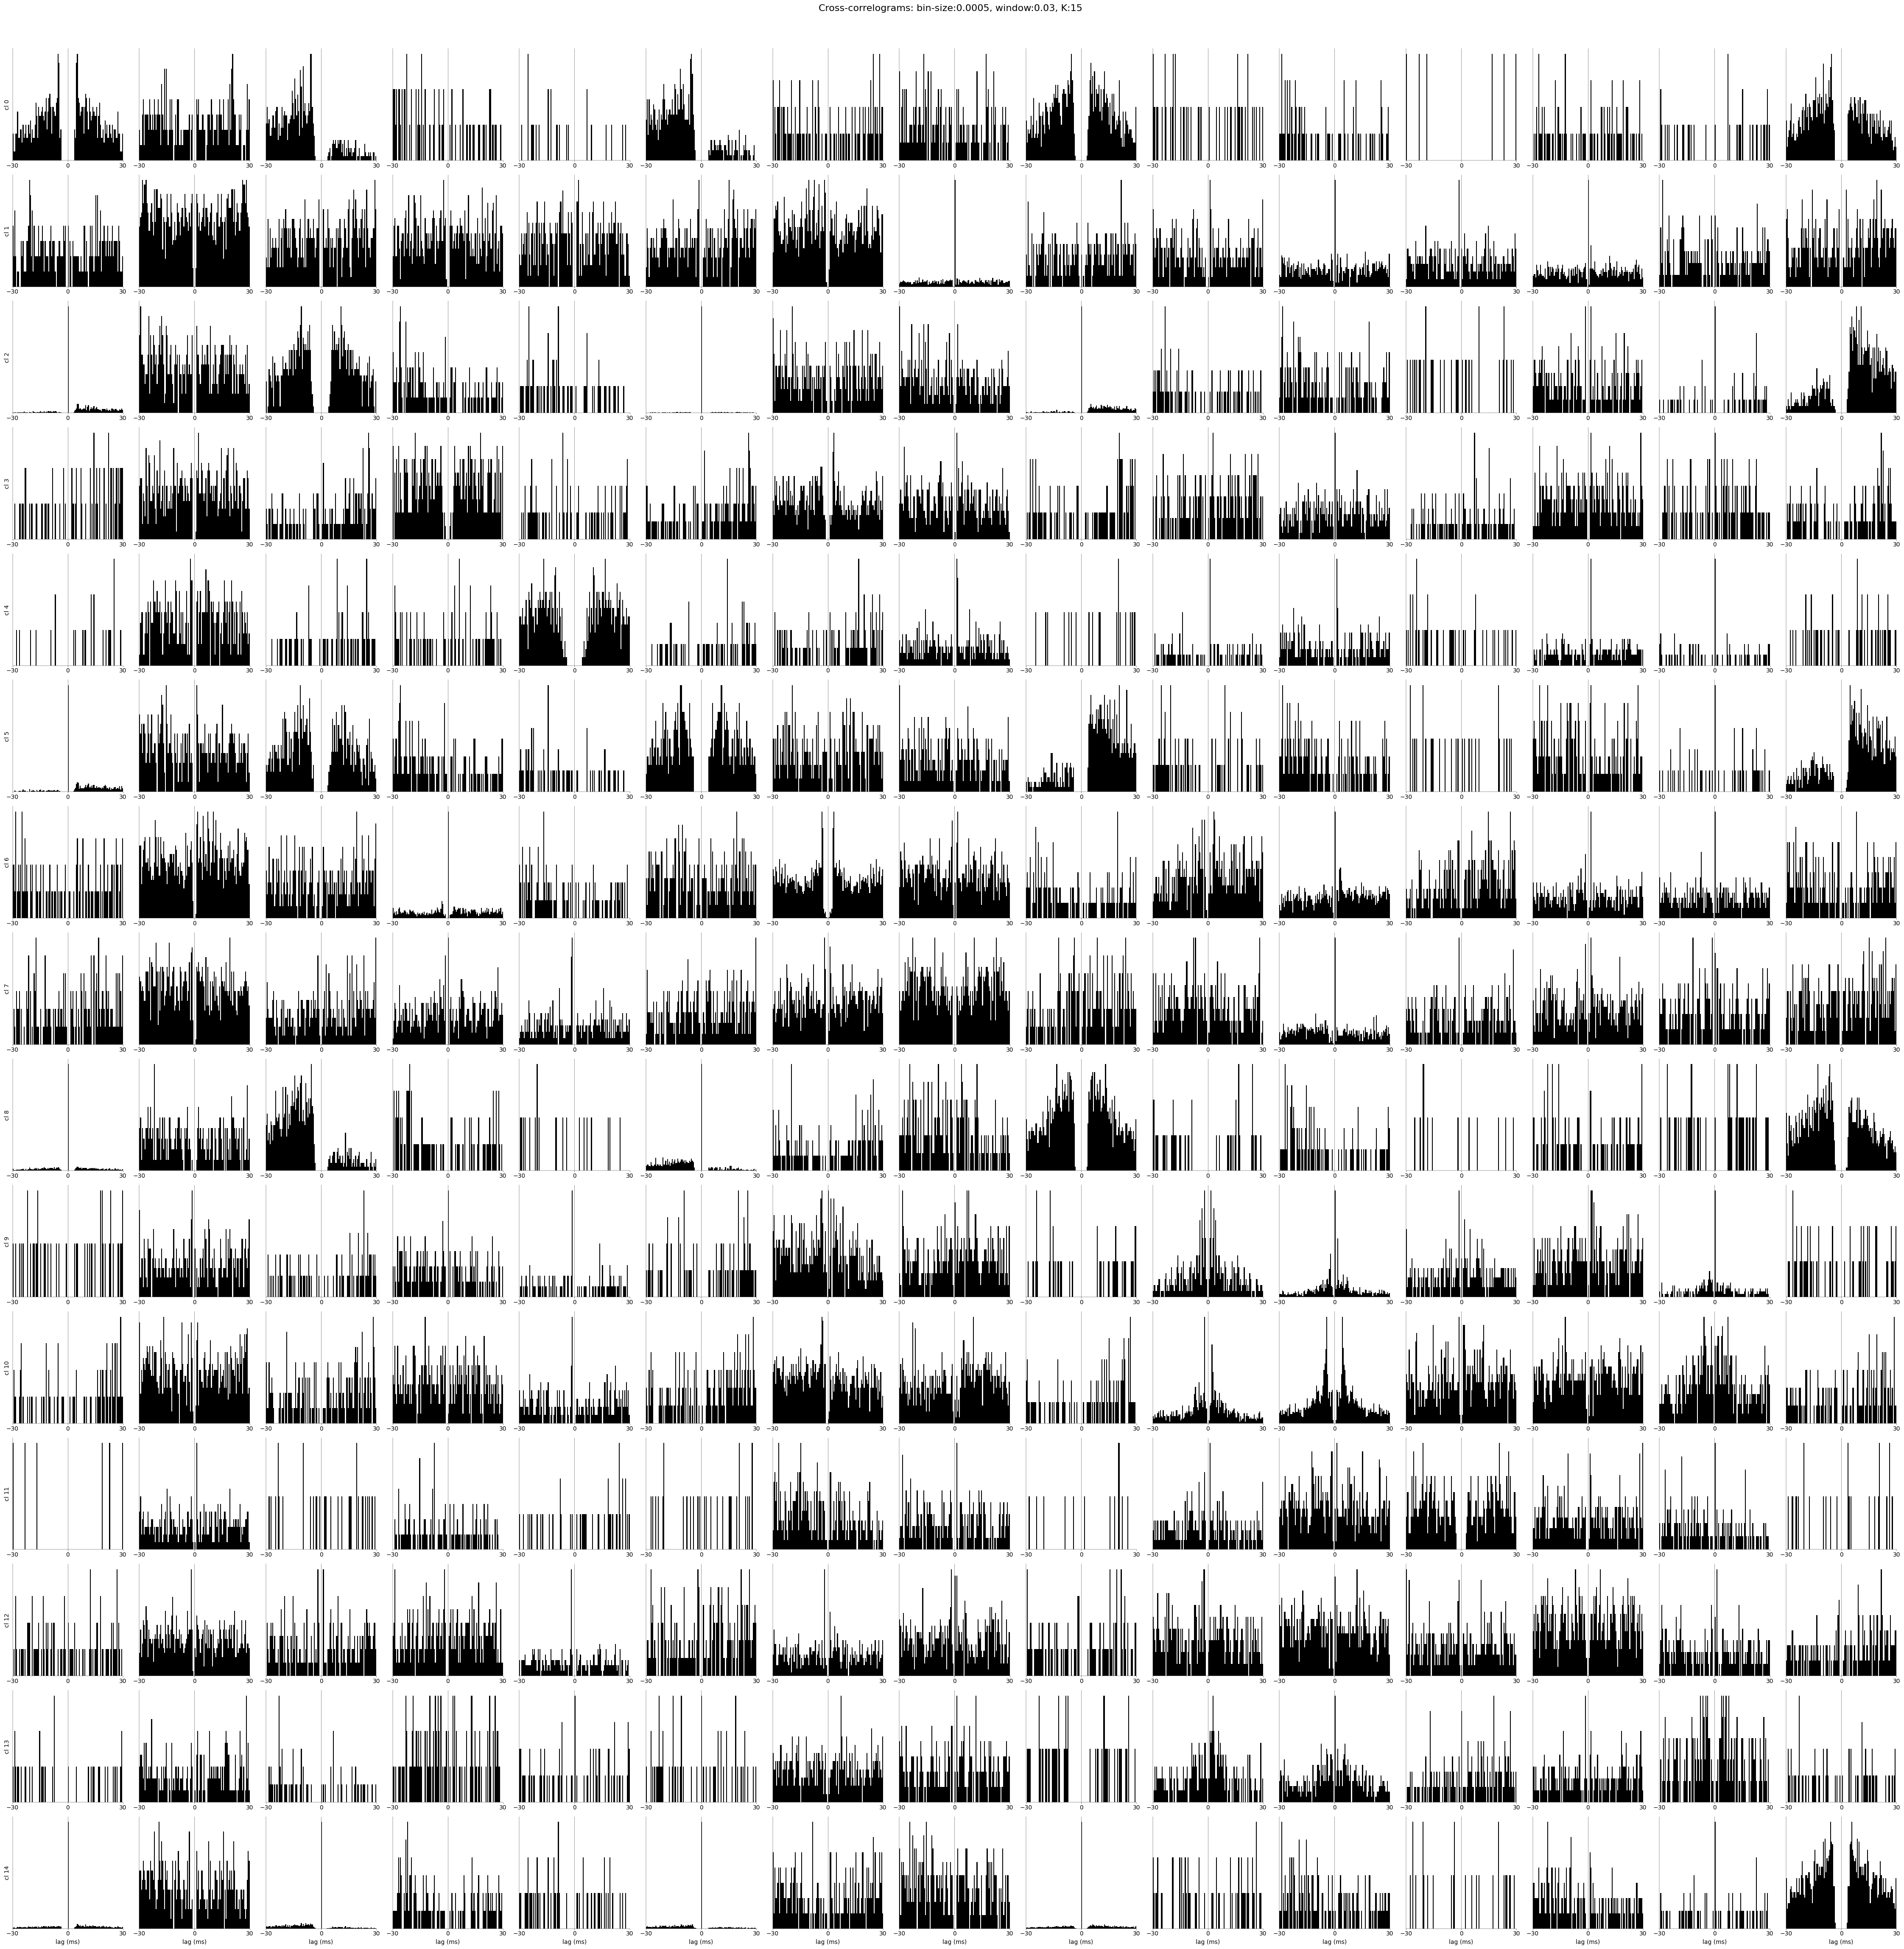

In [ ]:
fig, axes = plt.subplots(K, K, figsize=(3 * K, 3 * K))

corr = np.empty((K, K, n_bins), int)
centres = edges[:-1] + bin_size / 2

for i in range(K):
    for j in range(K):
        corr[i, j] = fast_histogram(times_by_cluster[i], times_by_cluster[j], edges)

np.save("corr_raw_counts.npy", corr)

for i in range(K):
    for j in range(K):
        ax = axes[i, j]
        counts = corr[i, j].copy()
        centre_mask = np.abs(centres) < (bin_size / 2)
        counts[centre_mask] = 0  # hide 0-lag spike
        ax.bar(centres * 1e3, counts, width=bin_size * 1e3, color="k")
        ax.set_xlim(-30, 30)
        ax.axvline(0, color="grey", lw=0.6)
        if i == K - 1:
            ax.set_xlabel("lag (ms)")
        if j == 0:
            ax.set_ylabel(f"cl {i}")
        ax.set_xticks([-30, 0, 30])
        ax.set_yticks([])
plt.tight_layout()
plt.suptitle(
    f"Cross-correlograms: bin-size:{bin_size}, window:{window}, K:{K} ",
    fontsize=16,
    y=1.02,
)
plt.savefig("correlograms.png", dpi=300)
plt.show()

/var/folders/_q/9l1zk1853mv45phss2fsffd00000gn/T/ipykernel_77314/4253030628.py:74: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Done


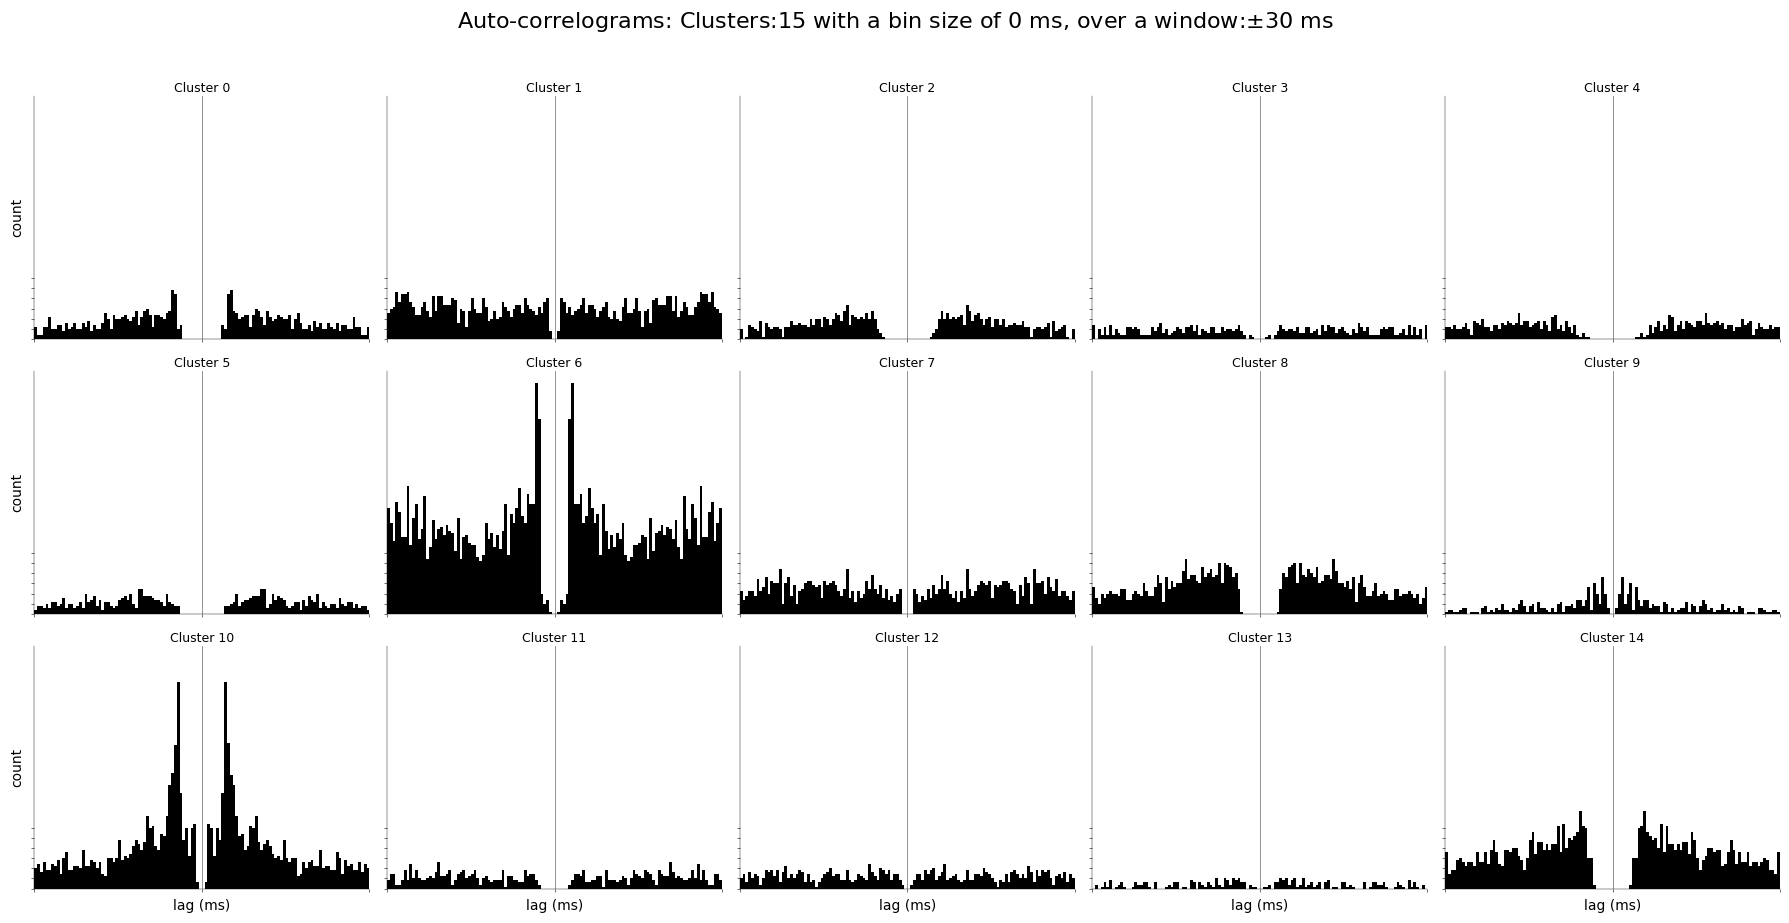

In [55]:
# %%
# Plot Auto-Correlograms Separately
def plot_autocorrelograms(
    corr: np.ndarray,
    centres: np.ndarray,
    *,
    max_lag_ms: float = 30,
    bin_size_s: float = 1e-3,
    cols: int = 4,
    figsize: tuple = (12, 8),
    y_label: str = "count",
    x_label: str = "lag (ms)",
):
    """
    Draw the K auto-correlograms sitting on the diagonal of *corr* and
    attach nice axis labels.

    Parameters
    ----------
    corr : (K, K, n_bins) int array
        Correlogram cube (full cross-matrix).  We plot corr[k, k].
    centres : 1-D float array
        Bin-centre positions **in seconds** (same length as the last dim).
    max_lag_ms, bin_size_s, cols, figsize … see earlier version
    """
    K = corr.shape[0]
    rows = int(np.ceil(K / cols))
    width_ms = bin_size_s * 1e3

    fig, axes = plt.subplots(
        rows, cols, figsize=figsize, sharex=True, sharey=True, squeeze=False
    )

    for k in range(K):
        r, c = divmod(k, cols)
        ax = axes[r, c]

        # make a local copy so we don’t overwrite the cube
        counts = corr[k, k].copy()
        centre_mask = np.abs(centres) < (bin_size_s / 2)
        counts[centre_mask] = 0  # hide 0-lag spike

        ax.bar(centres * 1e3, counts, width=width_ms, color="k")  # convert x to ms

        ax.set_xlim(-max_lag_ms, max_lag_ms)
        ax.axvline(0, color="grey", lw=0.6)
        ax.set_title(f"Cluster {k}", fontsize=9)

        # Put tick labels only on the outer panels to avoid clutter
        if r == rows - 1:  # bottom row – show x-tick labels
            ax.set_xlabel(x_label)
            ax.set_xticks([-max_lag_ms, 0, max_lag_ms])
        else:
            ax.set_xticklabels([])

        if c == 0:  # left column – show y-tick labels
            ax.set_ylabel(y_label)
            ax.set_yticks(ax.get_yticks())  # keep ticks
        else:
            ax.set_yticklabels([])

    # delete unused axes if K is not a multiple of *cols*
    for k in range(K, rows * cols):
        fig.delaxes(axes.flat[k])

    # fig.supxlabel(x_label, fontsize=12)
    # fig.supylabel(y_label, fontsize=12, x=0.04)
    fig.suptitle(
        f"Auto-correlograms: Clusters:{K} with a bin size of {bin_size_s*1e3:.0f} ms, over a window:$\pm${max_lag_ms:.0f} ms",
        fontsize=16,
        y=1.02,
    )

    fig.tight_layout()
    return fig


def run_plot_autocorrelograms(corr, bin_size: float = 0.001, window: float = 0.030):
    """
    Run the autocorrelogram plotting function with a given bin size and window.
    """
    edges = np.arange(-window, window + bin_size, bin_size)
    centres = edges[:-1] + bin_size / 2  # seconds
    max_lag_ms = window * 1e3  # ms
    bin_size_s = bin_size
    cols = 5  # 4 plots per row
    figsize = (18, 9)
    fig = plot_autocorrelograms(
        corr,
        centres,
        max_lag_ms=max_lag_ms,
        bin_size_s=bin_size_s,
        cols=cols,
        figsize=figsize,
    )
    fig.savefig("autocorrelograms.png", dpi=300)
    return fig


run_plot_autocorrelograms(corr, bin_size=bin_size, window=window)
print("Done")

### Questions
1) Based on the plot, do you see clusters that contain spikes likely from a single neuron?


The clusters (0, 2, 3, 4, 5, 6, 8, 11, 14)  are single unit clusters. The autocorrelograms  for these clusters show a pronounced dip of a few milliseconds around lag 0. The “refractory trough” is well-isolated, single neurons produce these, so these clusters are almost certainly ones that contain a single neuron. But across these clusters there might still be a possibility to merge clusters which are currently classified as separate by looking at the cross correlation between the single unit clusters to see if they have a common trough as well.

2) Do you see cases where plural clusters might come from the same neuron?

The clusters …..are probably plural clusters from the same neuron as their cross correlogram is indicating that they have the same refractory period. 

3) Do you see clusters that might contain spikes from plural neurons?

Clusters…  autocorrelogram is relatively flat around zero (no clear dip), suggesting it lacks a clean refractory period. That pattern often indicates multi-unit activity (i.e. spikes from more than one neuron mixed together), so cluster .. may contain plural neurons.

4) Explain the term "refractory period" and how one can see it in this plot.

A neuron’s refractory period is the brief interval of a few milliseconds after an action potential during which it cannot fire again. In an autocorrelogram this appears as a dip (very low counts) in the central bin and its immediate neighbors. That trough directly reflects the impossibility of two real spikes occurring closer than the cell’s biophysical refractory limit.